# Visualization of Stock Trading

In [1]:
# import libraries
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import datetime
import pandas_datareader.data as web

import matplotlib.pyplot as plt

In [2]:
# in case of error on notebook: Istll vega_datasets
#conda install -c conda-forge altair vega_datasets notebook vega
#see also https://altair-viz.github.io/getting_started/installation.html
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Set relevant parameters

In [3]:
#train_stock = 'data/GOOGL.csv'
#val_stock = 'data/AAPL_2018.csv'
window_size = 10
batch_size = 16
ep_count = 25 # for debugging, otherwise 15-50
model_name = 'model_Stefan'
pretrained = False
debug = False

## Load Dataset into pandas DataFrame

In [4]:
# read csv into dataframe
#df = pd.read_csv(val_stock)

# Setting Start and Enddate for Validation
start_train= datetime.datetime(2012, 1, 1)
end_train = datetime.datetime(2018, 1, 1)
start_val = end_train
end_val = datetime.datetime.now()


# Load Training and Validation data
# 1st. dataset as trading target
# 2nd. dataset as additional input feature

df_train = web.DataReader('AAPL','yahoo',
                               start=start_train, #start_train
                               end=end_train)  #end_train

df2_train = web.DataReader('GOLD','yahoo',
                               start=start_train, #start_train
                               end=end_train) #end_train


df_val = web.DataReader('AAPL','yahoo',
                               start=start_val, #start_train
                               end=end_val) #end_val
df2_val = web.DataReader('GOLD','yahoo',
                               start=start_val, #start_val
                               end=end_val)  #end_val

df = df_val # will be used to show actions and for plotting

#rename feature column names
df = df.rename(columns={'Adj Close': 'actual'})


# filter out the desired features



# Generate list objects
df_train_list = list(df_train['Adj Close'])
df_val_list = list(df_val['Adj Close'])
df2_train_list = list(df2_train['Adj Close'])
df2_val_list = list(df2_val['Adj Close'])



# Deleting obsolete dataframes
#del df_train
#del df2_val
#del df_train
#del df2_val

df.head()

# Open tast: Clean datasets (Adj Close, data that is not necessary)

,High,Low,Open,Close,Volume,actual
Date,,,,,,
2018-01-02,172.300003,169.259995,170.160004,172.259995,25555900.0,167.701889
2018-01-03,174.550003,171.960007,172.529999,172.229996,29517900.0,167.672668
2018-01-04,173.470001,172.080002,172.539993,173.029999,22434600.0,168.451508
2018-01-05,175.369995,173.050003,173.440002,175.000000,23660000.0,170.369385
2018-01-08,175.610001,173.929993,174.350006,174.350006,20567800.0,169.736588


In [5]:
#df_train.info()
#print(list(df_train['Adj Close']))



In [6]:
# convert dates from object to DateTime type
#dates = df['date']
#dates = pd.to_datetime(dates, infer_datetime_format=True)
#df['date'] = dates


In [7]:
#df.info()
#df.head()

day = df.index
print(day)
#print(df.head())

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2019-09-16', '2019-09-17', '2019-09-18', '2019-09-19',
               '2019-09-20', '2019-09-23', '2019-09-24', '2019-09-25',
               '2019-09-26', '2019-09-27'],
              dtype='datetime64[ns]', name='Date', length=438, freq=None)


In [8]:
#ttd = get_stock_data(train_stock)
#print(ttd[-5:])
df.head()

,High,Low,Open,Close,Volume,actual
Date,,,,,,
2018-01-02,172.300003,169.259995,170.160004,172.259995,25555900.0,167.701889
2018-01-03,174.550003,171.960007,172.529999,172.229996,29517900.0,167.672668
2018-01-04,173.470001,172.080002,172.539993,173.029999,22434600.0,168.451508
2018-01-05,175.369995,173.050003,173.440002,175.000000,23660000.0,170.369385
2018-01-08,175.610001,173.929993,174.350006,174.350006,20567800.0,169.736588


## Visualization of actions taken by Trading Bot

In [9]:
def visualize(df, history):
    # add history to dataframe
    position = [history[0][0]] + [x[0] for x in history]
    actions = ['HOLD'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    
    #alt.Chart(df.reset_index()).mark_line().encode(x='index')
    
    # specify y-axis scale for stock prices
    scale = alt.Scale(domain=(min(min(df['actual']), min(df['position'])) - 50, max(max(df['actual']), max(df['position'])) + 50), clamp=True)
    
    # plot a line chart for stock positions
    actual = alt.Chart(df.reset_index()).mark_line(
        color='green',
        opacity=0.5
    ).encode(
        x='Date:T', #'date:T'
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale)
    ).interactive(
        bind_y=False
    )
    
    # plot the BUY and SELL actions as points
    points = alt.Chart(df.reset_index()).transform_filter(
        alt.datum.action != 'HOLD'
    ).mark_point(
        filled=True
    ).encode(
        x=alt.X('Date:T', axis=alt.Axis(title='Date')),
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale),
        color='action'
        #color=alt.Color('action', scale=alt.Scale(range=['blue', 'red']))
    ).interactive(bind_y=False)

    # merge the two charts
    chart = alt.layer(actual, points, title="your stock").properties(height=300, width=1000)
    
    return chart

In [10]:
#print(df.head())
#train_data2
print(ep_count)

25


## Training the model

In [11]:
import logging
import coloredlogs

from train import *
from evaluate import show_eval_result

coloredlogs.install(level='DEBUG')
switch_k_backend_device() #switches to CPU (acc. to author faster than GPU)


train_data = df_train_list  
val_data = df_val_list 
train_data2 = df2_train_list #None
val_data2 = df2_val_list # None



if train_data2 is not None:
    agent = Agent(window_size*2, pretrained=False, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=False, model_name=model_name)

initial_offset = val_data[1] - val_data[0]

reslist_t =[] # Train Reward for plotting
reslist_v = [] # Val Reward for plotting
for i in range(1, ep_count + 1): 
    train_result = train_model(agent, i, train_data, train_data2, ep_count=ep_count,
                                batch_size=batch_size, window_size=window_size)
    val_result, _ = evaluate_model(agent, val_data, val_data2, window_size, debug)
    show_train_result(train_result, val_result, initial_offset)
    reslist_t.append(train_result[2]) # append reward of training
    reslist_v.append(val_result)
    

Using TensorFlow backend.


[[0.5        0.5        0.5        0.5        0.00247262 0.99330715]]
(1, 6)


I0929 16:37:11.540947 15608 train.py:157] switching to TensorFlow for CPU
2019-09-29 16:37:11 PC-Stefan root[20020] DEBUG switching to TensorFlow for CPU
W0929 16:37:11.572204 15608 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2019-09-29 16:37:11 PC-Stefan tensorflow[20020] WARNING From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0929 16:37:11.584530 15608 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

2019-09-29 16:37:11 PC-Stefan tensorflow[20020] WARNING From C:\ProgramData\Anaconda3\envs\2019\lib\site

Episode 13/25: 100%|██████████| 1508/1508 [00:14<00:00, 101.69it/s]
I0929 16:40:24.024721 15608 train.py:148] Episode 13/25 - Train Position: +$92.40  Val Position: +$85.66  Train Loss: 0.0719  (~14.8259 secs)
2019-09-29 16:40:24 PC-Stefan root[20020] INFO Episode 13/25 - Train Position: +$92.40  Val Position: +$85.66  Train Loss: 0.0719  (~14.8259 secs)
Episode 14/25: 100%|██████████| 1508/1508 [00:14<00:00, 103.15it/s]
I0929 16:40:38.774688 15608 train.py:148] Episode 14/25 - Train Position: -$69.29  Val Position: +$4.10  Train Loss: 0.0808  (~14.6223 secs)
2019-09-29 16:40:38 PC-Stefan root[20020] INFO Episode 14/25 - Train Position: -$69.29  Val Position: +$4.10  Train Loss: 0.0808  (~14.6223 secs)
Episode 15/25: 100%|██████████| 1508/1508 [00:14<00:00, 101.76it/s]
I0929 16:40:53.734417 15608 train.py:148] Episode 15/25 - Train Position: +$153.89  Val Position: +$38.78  Train Loss: 0.0892  (~14.8232 secs)
2019-09-29 16:40:53 PC-Stefan root[20020] INFO Episode 15/25 - Train Position

I0929 16:43:18.304247 15608 font_manager.py:1259] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
I0929 16:43:18.304247 15608 font_manager.py:1271] findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
I0929 16:43:18.317790 15608 font_manager.py:1271] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
I0929 16:43:18.317790 15608 font_

2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 0.33499999999999996
I0929 16:43:18.467984 15608 font_manager.py:1271] findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
I0929 16:43:18.483614 15608 font_manager.py:1271] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
I0929 16:43:18.483614 15608 font_manager.py:1271] findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEB

2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Britannic Bold' (BRITANIC.TTF) normal normal bold normal>) = 10.335
I0929 16:43:18.683473 15608 font_manager.py:1271] findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
I0929 16:43:18.704308 15608 font_manager.py:1271] findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 11.05
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 11.05
I0929 16:43:18.704308 15608 font_manager.py:1271] findfont: score(<Font 'Script MT Bold' (SCRIPTBL.TTF) normal normal bold normal>) = 10.335
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Script MT Bold' (SCRIPTBL.TTF) normal normal bold norma

2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Pristina' (PRISTINA.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:18.917980 15608 font_manager.py:1271] findfont: score(<Font 'Parchment' (PARCHM.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Parchment' (PARCHM.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:18.917980 15608 font_manager.py:1271] findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal bold condensed>) = 10.535
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal bold condensed>) = 10.535
I0929 16:43:18.933611 15608 font_manager.py:1271] findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal book normal>) = 10.05
2019-09-29 16:43:18 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal

2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Poor Richard' (POORICH.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:19.154647 15608 font_manager.py:1271] findfont: score(<Font 'Lucida Fax' (LFAXI.TTF) italic normal 400 normal>) = 11.05
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Lucida Fax' (LFAXI.TTF) italic normal 400 normal>) = 11.05
I0929 16:43:19.167871 15608 font_manager.py:1271] findfont: score(<Font 'Corbel' (corbelli.ttf) italic normal light normal>) = 11.24
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Corbel' (corbelli.ttf) italic normal light normal>) = 11.24
I0929 16:43:19.167871 15608 font_manager.py:1271] findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal bold condensed>) = 6.8986363636363635
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal bold condens

2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Rockwell Condensed' (ROCC____.TTF) normal normal 400 condensed>) = 10.25
I0929 16:43:19.383464 15608 font_manager.py:1271] findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
I0929 16:43:19.399094 15608 font_manager.py:1271] findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
I0929 16:43:19.405246 15608 font_manager.py:1271] findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Haettenschweiler' (HATTEN.TT

2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal bold normal>) = 10.335
I0929 16:43:19.601773 15608 font_manager.py:1271] findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
I0929 16:43:19.601773 15608 font_manager.py:1271] findfont: score(<Font 'Wingdings 2' (WINGDNG2.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Wingdings 2' (WINGDNG2.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:19.617910 15608 font_manager.py:1271] findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 normal>) = 11.05
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 no

2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Gadugi' (gadugib.ttf) normal normal bold normal>) = 10.335
I0929 16:43:19.837477 15608 font_manager.py:1271] findfont: score(<Font 'Old English Text MT' (OLDENGL.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Old English Text MT' (OLDENGL.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:19.854334 15608 font_manager.py:1271] findfont: score(<Font 'Gill Sans Ultra Bold' (GILSANUB.TTF) normal normal bold normal>) = 10.335
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Gill Sans Ultra Bold' (GILSANUB.TTF) normal normal bold normal>) = 10.335
I0929 16:43:19.854334 15608 font_manager.py:1271] findfont: score(<Font 'Rockwell' (ROCKBI.TTF) italic normal bold normal>) = 11.335
2019-09-29 16:43:19 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Rockwell' (ROC

2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Garamond' (GARA.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:20.083451 15608 font_manager.py:1271] findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
I0929 16:43:20.099077 15608 font_manager.py:1271] findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal bold normal>) = 10.335
2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal bold normal>) = 10.335
I0929 16:43:20.102389 15608 font_manager.py:1271] findfont: score(<Font 'Eras Light ITC' (ERASLGHT.TTF) normal normal light normal>) = 10.24
2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Eras Light ITC' (ERASLGHT.T

2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
I0929 16:43:20.302351 15608 font_manager.py:1271] findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
I0929 16:43:20.302351 15608 font_manager.py:1271] findfont: score(<Font 'Bell MT' (BELL.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Bell MT' (BELL.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:20.302351 15608 font_manager.py:1271] findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
I0929 16:

2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
I0929 16:43:20.488546 15608 font_manager.py:1271] findfont: score(<Font 'Tw Cen MT' (TCB_____.TTF) normal normal bold normal>) = 10.335
2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Tw Cen MT' (TCB_____.TTF) normal normal bold normal>) = 10.335
I0929 16:43:20.504682 15608 font_manager.py:1271] findfont: score(<Font 'Rockwell Extra Bold' (ROCKEB.TTF) normal normal bold normal>) = 10.335
2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Rockwell Extra Bold' (ROCKEB.TTF) normal normal bold normal>) = 10.335
I0929 16:43:20.517783 15608 font_manager.py:1271] findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal bold normal>) = 11.335
2019-09-29 16:43:20 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Consolas' (consolaz.

2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
I0929 16:43:21.217947 15608 font_manager.py:1271] findfont: score(<Font 'Myanmar Text' (mmrtext.ttf) normal normal 400 normal>) = 10.05
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Myanmar Text' (mmrtext.ttf) normal normal 400 normal>) = 10.05
I0929 16:43:21.233580 15608 font_manager.py:1271] findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
I0929 16:43:21.233580 15608 font_manager.py:1271] findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal normal 400 normal>) = 10.05
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal norma

2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
I0929 16:43:21.420003 15608 font_manager.py:1271] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
I0929 16:43:21.436135 15608 font_manager.py:1271] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
I0929 16:43:21.436135 15608 font_manager.py:1271] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manag

2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Baskerville Old Face' (BASKVILL.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:21.620113 15608 font_manager.py:1271] findfont: score(<Font 'Forte' (FORTE.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Forte' (FORTE.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:21.635739 15608 font_manager.py:1271] findfont: score(<Font 'Arial' (arialbd.ttf) normal normal bold normal>) = 6.698636363636363
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Arial' (arialbd.ttf) normal normal bold normal>) = 6.698636363636363
I0929 16:43:21.635739 15608 font_manager.py:1271] findfont: score(<Font 'Segoe UI' (seguili.ttf) italic normal light normal>) = 11.24
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Segoe UI' (seguili.ttf) italic normal ligh

2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
I0929 16:43:21.816752 15608 font_manager.py:1271] findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:21.816752 15608 font_manager.py:1271] findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal book normal>) = 10.05
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal book normal>) = 10.05
I0929 16:43:21.832378 15608 font_manager.py:1271] findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 no

2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Berlin Sans FB' (BRLNSB.TTF) normal normal bold normal>) = 10.335
I0929 16:43:21.973012 15608 font_manager.py:1271] findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal bold normal>) = 10.335
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal bold normal>) = 10.335
I0929 16:43:21.988638 15608 font_manager.py:1271] findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal light normal>) = 11.24
2019-09-29 16:43:21 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal light normal>) = 11.24
I0929 16:43:22.005461 15608 font_manager.py:1271] findfont: score(<Font 'Cambria' (cambriab.ttf) normal normal bold normal>) = 10.335
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Cambria' (cambriab.ttf) normal nor

2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Book Antiqua' (ANTQUAB.TTF) normal normal book normal>) = 10.05
I0929 16:43:22.205176 15608 font_manager.py:1271] findfont: score(<Font 'Tw Cen MT' (TCMI____.TTF) italic normal 400 normal>) = 11.05
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Tw Cen MT' (TCMI____.TTF) italic normal 400 normal>) = 11.05
I0929 16:43:22.205176 15608 font_manager.py:1271] findfont: score(<Font 'Franklin Gothic Heavy' (FRAHV.TTF) normal normal heavy normal>) = 10.43
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Franklin Gothic Heavy' (FRAHV.TTF) normal normal heavy normal>) = 10.43
I0929 16:43:22.221312 15608 font_manager.py:1271] findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal bold normal>) = 10.335
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Palatino Linotype' (pal

2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Impact' (impact.ttf) normal normal 400 normal>) = 10.05
I0929 16:43:22.437709 15608 font_manager.py:1271] findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:22.437709 15608 font_manager.py:1271] findfont: score(<Font 'Palatino Linotype' (palai.ttf) italic normal 400 normal>) = 11.05
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Palatino Linotype' (palai.ttf) italic normal 400 normal>) = 11.05
I0929 16:43:22.453339 15608 font_manager.py:1271] findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal bold normal>) = 10.335
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal bo

2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Candara' (Candarai.ttf) italic normal 400 normal>) = 11.05
I0929 16:43:22.666959 15608 font_manager.py:1271] findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
I0929 16:43:22.685725 15608 font_manager.py:1271] findfont: score(<Font 'Dubai' (DUBAI-LIGHT.TTF) normal normal light normal>) = 10.24
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Dubai' (DUBAI-LIGHT.TTF) normal normal light normal>) = 10.24
I0929 16:43:22.685725 15608 font_manager.py:1271] findfont: score(<Font 'Rockwell' (ROCK.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Rockwell' (ROCK.TTF) normal normal 400 normal>) = 10.05
I0

2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal bold normal>) = 10.335
I0929 16:43:22.851759 15608 font_manager.py:1271] findfont: score(<Font 'French Script MT' (FRSCRIPT.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'French Script MT' (FRSCRIPT.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:22.871977 15608 font_manager.py:1271] findfont: score(<Font 'Gigi' (GIGI.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Gigi' (GIGI.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:22.871977 15608 font_manager.py:1271] findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal bold normal>) = 10.335
2019-09-29 16:43:22 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal bold normal>) = 1

2019-09-29 16:43:23 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Californian FB' (CALIFB.TTF) normal normal bold normal>) = 10.335
I0929 16:43:23.070903 15608 font_manager.py:1271] findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
2019-09-29 16:43:23 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
I0929 16:43:23.087734 15608 font_manager.py:1271] findfont: score(<Font 'Ebrima' (ebrima.ttf) normal normal 400 normal>) = 10.05
2019-09-29 16:43:23 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Ebrima' (ebrima.ttf) normal normal 400 normal>) = 10.05
I0929 16:43:23.087734 15608 font_manager.py:1271] findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
2019-09-29 16:43:23 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05

2019-09-29 16:43:23 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal medium condensed>) = 10.344999999999999
I0929 16:43:23.955229 15608 font_manager.py:1271] findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
2019-09-29 16:43:23 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
I0929 16:43:23.955229 15608 font_manager.py:1271] findfont: score(<Font 'Vivaldi' (VIVALDII.TTF) italic normal 400 normal>) = 11.05
2019-09-29 16:43:23 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Vivaldi' (VIVALDII.TTF) italic normal 400 normal>) = 11.05
I0929 16:43:23.967901 15608 font_manager.py:1271] findfont: score(<Font 'Tahoma' (tahoma.ttf) normal normal 400 normal>) = 10.05
2019-09-29 16:43:23 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: score(<Font 'Tahoma' (tahoma.ttf) normal no

2019-09-29 16:43:24 PC-Stefan matplotlib.font_manager[20020] DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\ProgramData\\Anaconda3\\envs\\2019\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.


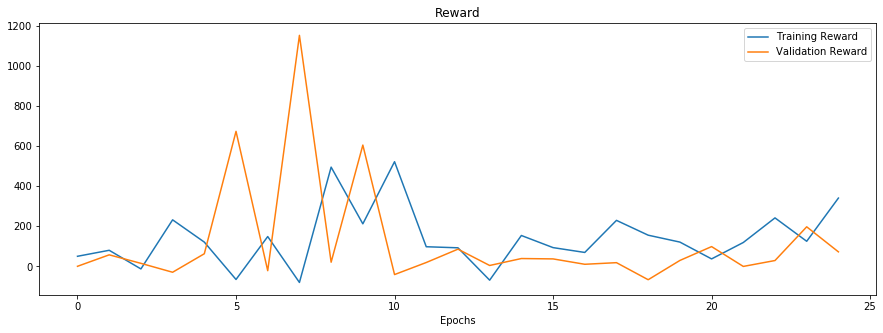

In [12]:
# Plotting Result
plt.figure(figsize = (15,5))
plt.plot(reslist_t, label = "Training Reward");
plt.plot(reslist_v, label = "Validation Reward");
plt.title("Reward")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Plotting the evaluation actions

I0929 18:13:50.804237 15608 evaluate.py:111] model_Stefan: +$72.19

2019-09-29 18:13:50 PC-Stefan root[20020] INFO model_Stefan: +$72.19



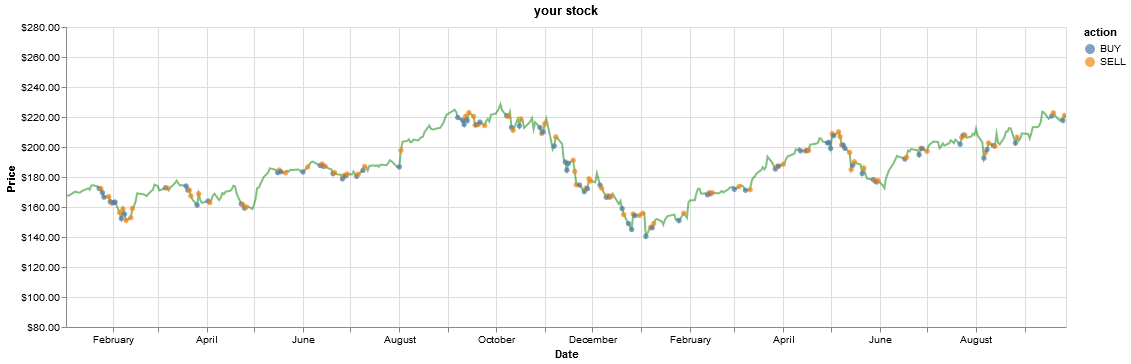

In [21]:
val_result, history = evaluate_model(agent, val_data,val_data2, window_size, debug)
show_eval_result(model_name, val_result, initial_offset)
chart = visualize(df, history)
chart

In [23]:
df.tail()

,High,Low,Open,Close,Volume,actual,position,action
Date,,,,,,,,
2019-09-23,219.839996,217.649994,218.949997,218.720001,19165500.0,218.720001,217.729996,HOLD
2019-09-24,222.490005,217.190002,221.029999,217.679993,31190800.0,217.679993,218.720001,HOLD
2019-09-25,221.500000,217.139999,218.550003,221.029999,21903400.0,221.029999,217.679993,BUY
2019-09-26,220.940002,218.830002,220.000000,219.889999,18833500.0,219.889999,221.029999,SELL
2019-09-27,220.960007,217.279999,220.539993,218.820007,25352000.0,218.820007,219.889999,HOLD


## Testing the Model

I0929 16:50:32.345357 15608 connectionpool.py:813] Starting new HTTPS connection (1): finance.yahoo.com:443
2019-09-29 16:50:32 PC-Stefan urllib3.connectionpool[20020] DEBUG Starting new HTTPS connection (1): finance.yahoo.com:443
I0929 16:50:32.751634 15608 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/GooG/history?period1=1514775600&period2=1569808799&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-09-29 16:50:32 PC-Stefan urllib3.connectionpool[20020] DEBUG https://finance.yahoo.com:443 "GET /quote/GooG/history?period1=1514775600&period2=1569808799&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
I0929 16:50:32.912188 15608 connectionpool.py:813] Starting new HTTPS connection (1): finance.yahoo.com:443
2019-09-29 16:50:32 PC-Stefan urllib3.connectionpool[20020] DEBUG Starting new HTTPS connection (1): finance.yahoo.com:443
I0929 16:50:33.318168 15608 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/GOLD/history?period1=151

Earnings of Model:  317.92022705078125


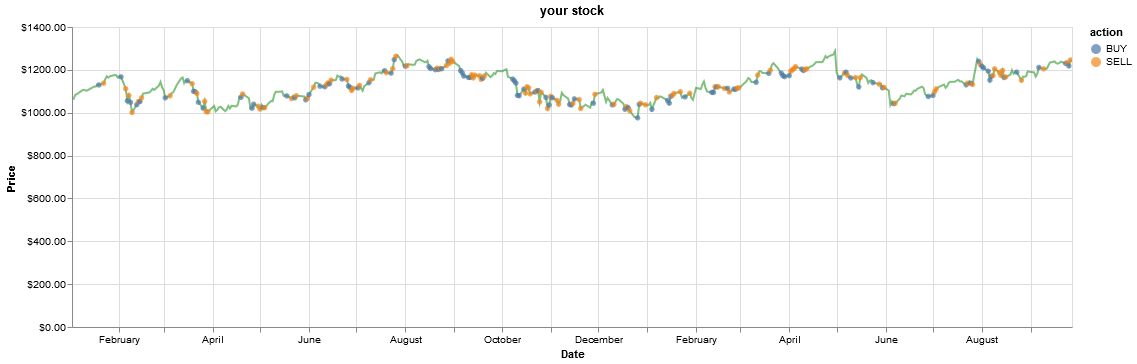

In [20]:
# Loading Test Data

# Setting Start and Enddate for Validation
start_test = datetime.datetime(2018, 1, 1)
end_test = datetime.datetime.now()

# Load Test Data
df_test = web.DataReader('GooG','yahoo',
                               start=start_test, 
                               end=end_test)

df2_test = web.DataReader('GOLD','yahoo',
                               start=start_test, 
                               end=end_test)

dft = df_test # will be used to show actions and for plotting

#rename feature column names
dft = dft.rename(columns={'Adj Close': 'actual'})


# Generate list objects
df_test_list = list(df_test['Adj Close'])
df2_test_list = list(df2_test['Adj Close'])


# Deleting obsolete dataframes
del df_test
del df2_test

test_data = df_test_list
test_data2 = df2_test_list


val_result, history = evaluate_model(agent, test_data, test_data2, window_size, debug)
show_eval_result(model_name, val_result, initial_offset)
chart = visualize(df, history)
print("Earnings of Model: ", val_result)
chart

